In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf


In [ ]:
import urllib.request
import zipfile
import os

# 파일 다운로드 및 압축 해제 함수
def download_and_unzip(url, extract_to='.'):

    # 파일 이름 추출
    filename = url.split('/')[-1]
    filepath = os.path.join(extract_to, filename)
    
    # URL에서 파일 다운로드
    print(f"Downloading {filename} from {url}...")
    urllib.request.urlretrieve(url, filepath)
    
    # Zip 파일 압축 해제
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    # 다운로드된 zip 파일 삭제
    print(f"Removing {filename}...")
    os.remove(filepath)
    print(f"Completed. Extracted to {extract_to}")


os.makedirs('./UCF101', exist_ok=True)
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_and_unzip(URL, './UCF101')  


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:

        print(e)

**Data Preprocessing**

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "./UCF101/UCF101"
CLASS_INDEX_FILE = "UCF101_labels.txt"  

In [4]:
def load_class_index(class_index_file):
    class_labels = {}
    with open(class_index_file, 'r') as file:
        for line in file:
            index, label = line.split()
            class_labels[label] = int(index) - 1  # 0부터 시작하도록 인덱스 조정
    return class_labels

class_labels = load_class_index(CLASS_INDEX_FILE)

In [5]:
def frames_extraction(video_path, num_frames=20):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    

    frames_indices = np.random.choice(range(video_frames_count), size=num_frames, replace=False)
    frames_indices = sorted(frames_indices) 
    
    for frame_idx in frames_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = video_reader.read()
        if not success:
            continue  

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
        
        
    video_reader.release()
    return frames_list

In [8]:
def create_dataset(dataset_dir, class_labels):
    features, labels = [], []
    files_list = os.listdir(dataset_dir)
    a =1
    for file_name in files_list:
        class_name = file_name.split('_')[1]  # 파일명에서 클래스 이름 추출
        video_file_path = os.path.join(dataset_dir, file_name)

        frames = frames_extraction(video_file_path) 
        progress_percentage = (a / 13320) * 100
        print(f"Progress: {progress_percentage:.4f}%")
        a+=1
        if len(frames) == SEQUENCE_LENGTH:
            features.append(frames)
            labels.append(class_labels[class_name])
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, to_categorical(labels, num_classes=len(class_labels))

features, labels = create_dataset(DATASET_DIR, class_labels)
one_hot_encoded_labels = to_categorical(labels)

Progress: 0.0075%
Progress: 0.0150%
Progress: 0.0225%
Progress: 0.0300%
Progress: 0.0375%
Progress: 0.0450%
Progress: 0.0526%
Progress: 0.0601%
Progress: 0.0676%
Progress: 0.0751%
Progress: 0.0826%
Progress: 0.0901%
Progress: 0.0976%
Progress: 0.1051%
Progress: 0.1126%
Progress: 0.1201%
Progress: 0.1276%
Progress: 0.1351%
Progress: 0.1426%
Progress: 0.1502%
Progress: 0.1577%
Progress: 0.1652%
Progress: 0.1727%
Progress: 0.1802%
Progress: 0.1877%
Progress: 0.1952%
Progress: 0.2027%
Progress: 0.2102%
Progress: 0.2177%
Progress: 0.2252%
Progress: 0.2327%
Progress: 0.2402%
Progress: 0.2477%
Progress: 0.2553%
Progress: 0.2628%
Progress: 0.2703%
Progress: 0.2778%
Progress: 0.2853%
Progress: 0.2928%
Progress: 0.3003%
Progress: 0.3078%
Progress: 0.3153%
Progress: 0.3228%
Progress: 0.3303%
Progress: 0.3378%
Progress: 0.3453%
Progress: 0.3529%
Progress: 0.3604%
Progress: 0.3679%
Progress: 0.3754%
Progress: 0.3829%
Progress: 0.3904%
Progress: 0.3979%
Progress: 0.4054%
Progress: 0.4129%
Progress: 

In [9]:
def save_dataset(features, labels, filename='dataset.npz'):
    np.savez(filename, features=features, labels=labels)
    print(f"Dataset saved as {filename}")


save_dataset(features, labels, 'ucf101_dataset_random.npz')


Dataset saved as ucf101_dataset_random.npz


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def create_lstm_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(20, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))
    model.add(Dense(101, activation='softmax')) 

    model.summary()
    return model


def generator(features, labels):
    for feature, label in zip(features, labels):
        yield feature, label

def load_dataset_in_batches(filename, batch_size):
    data = np.load(filename, allow_pickle=True, mmap_mode='r')
    features = data['features'].astype(np.float32)  
    labels = data['labels']

  

    features_train, features_temp, labels_train, labels_temp = train_test_split(features, labels, test_size=0.2, random_state=42)

    features_val, features_test, labels_val, labels_test = train_test_split(features_temp, labels_temp, test_size=0.5, random_state=42)


    train_dataset = tf.data.Dataset.from_generator(lambda: generator(features_train, labels_train),
                                                   output_types=(features.dtype, labels.dtype),
                                                   output_shapes=(features_train.shape[1:], labels_train.shape[1:])).batch(batch_size)
    
    test_dataset = tf.data.Dataset.from_generator(lambda: generator(features_test, labels_test),
                                                  output_types=(features.dtype, labels.dtype),
                                                  output_shapes=(features_test.shape[1:], labels_test.shape[1:])).batch(batch_size)
    
    val_dataset = tf.data.Dataset.from_generator(lambda: generator(features_val, labels_val),
                                                output_types=(features.dtype, labels.dtype),
                                                output_shapes=(features_test.shape[1:], labels_val.shape[1:])).batch(batch_size)


    return train_dataset, test_dataset, val_dataset


# 모델 생성
lstm_model = create_lstm_model()
print("Model Created Successfully!")


batch_size = 4
train_dataset, test_dataset, val_dataset = load_dataset_in_batches('ucf101_dataset.npz', batch_size=batch_size)

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

lstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

lstm_model_training_history = lstm_model.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[early_stopping_callback])

model_path = 'lstm_model_random.h5'
lstm_model.save(model_path)
print(f"모델이 '{model_path}'에 저장되었습니다.")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 20, 4, 4, 32)    

In [11]:
test_loss, test_accuracy =lstm_model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

333/333 [==============================] - 2s 5ms/step - loss: 1.6124 - accuracy: 0.5961
Test Loss: 1.6123954057693481
Test Accuracy: 0.5960960984230042


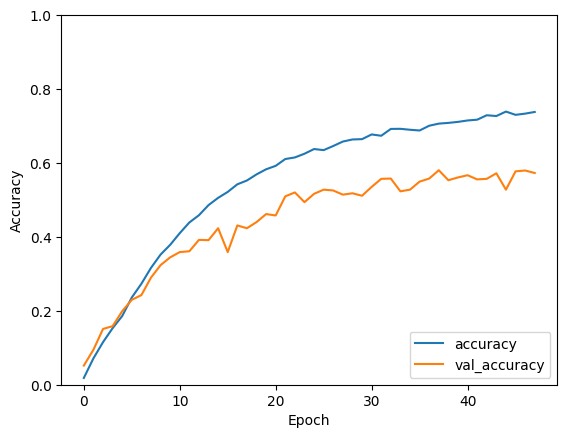

In [12]:
# 학습 과정 출력
plt.plot(lstm_model_training_history.history['accuracy'], label='accuracy')
plt.plot(lstm_model_training_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()